# **Imports**

In [134]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
!pip install utils
!pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [136]:
from pandas.testing import *

import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
#from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [137]:
##All imports


import numpy as np
import os
import sys
import time
import io
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import logging
import plotly.graph_objects as go
# import talos as ta
from google.colab import files


##Other os related stuff
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger("tensorflow").setLevel(logging.ERROR)
os.environ['TZ'] = 'Asia/Tehran'  # to set timezone; needed when running on cloud
time.tzset()



# **3. Data**




## > **3.1. Correlated Assets**
https://www.portfoliovisualizer.com/asset-correlations
https://unicornbay.com/tools/most-less-correlated-assets



### **3.1.1 Data Preparation**

In [138]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [139]:
url = 'https://raw.githubusercontent.com/berserkhmdvhb/stockdata-public/master/ge.us.txt'
df_gs = pd.read_csv(url)

df_gs.drop(df_gs.columns[[1,2,3,5,6]], axis=1,inplace=True)
df_gs.columns = ['Date','GS']
df_gs['Date'] = pd.to_datetime(df_gs['Date'], format='%Y-%m-%d')


In [140]:

print(df_gs.head())
print(df_gs.tail(),'\n\n')



        Date      GS
0 1962-01-02  0.6201
1 1962-01-03  0.6201
2 1962-01-04  0.6122
3 1962-01-05  0.5957
4 1962-01-08  0.5957
            Date     GS
14053 2017-11-06  20.13
14054 2017-11-07  20.21
14055 2017-11-08  20.12
14056 2017-11-09  19.99
14057 2017-11-10  20.49 




In [141]:
df_gs.dropna()

,Date,GS
0,1962-01-02,0.6201
1,1962-01-03,0.6201
2,1962-01-04,0.6122
3,1962-01-05,0.5957
4,1962-01-08,0.5957
...,...,...
14053,2017-11-06,20.1300
14054,2017-11-07,20.2100
14055,2017-11-08,20.1200
14056,2017-11-09,19.9900


In [142]:
print('There are {} number of days in the dataset of General Electrics. \n'.format(df_gs.shape[0]))

There are 14058 number of days in the dataset of General Electrics. 



In [143]:
df_train, df_test = train_test_split(df_gs, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))

Train--Test size 11246 2812


In [144]:
df_gs.Date[11000]

Timestamp('2005-09-21 00:00:00')

In [145]:
#df_gs.set_index('Date', inplace=True)

In [146]:
#df_gs_b = df_gs.copy()

### **3.1.2 Data Visualization**

In [147]:
##Visualize Correlated Stocks

###Visaulise 400 days
def plot_stocks(dataset1):
    plt.figure(figsize=(18, 5), dpi=100)
    shape_0 = dataset1.shape[0]

    #x_ = range(3, dataset.shape[0])
    #x_ =list(dataset.index)
    plt.plot(dataset1['Date'],dataset1.iloc[:, 1],color = 'g', label='General Electric stock')
    #plt.plot(dataset2['Date'], dataset2.iloc[:, 1],color = 'r', label='Goldman Sachs stock')
    #plt.plot(dataset3['Date'], dataset3.iloc[:, 1],color = 'c', label='Goldman Sachs stock')
    #plt.vlines(datetime.date(2005,9, 21), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
    plt.vlines(datetime.date(2005,9,21), 0, 50, linestyles='--', colors='gray', label='Train/Test data cut-off')
    plt.xlabel('Date')
    plt.ylabel('USD')
    plt.title('Figure 2: General Electric stock price')
    plt.legend()
    plt.savefig('stock.png')
    plt.show()

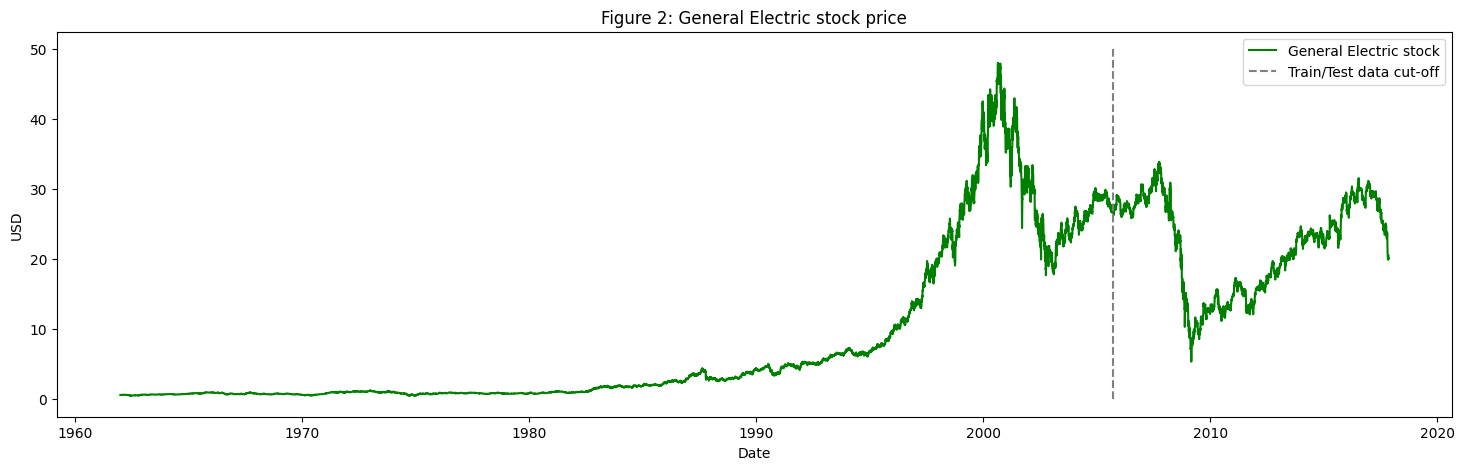

In [148]:
plot_stocks(df_gs)

In [149]:
#files.download('stock.png')



## **3.2. Technical Indicators**



In [150]:
## ma: Moving Average
## MACD: Moving Average Convergence Divergence
## ema: Exponential Moving Average
def get_technical_indicators(datasetinput):
    length = datasetinput.shape[0]
    dataset = datasetinput.copy()
    column_names = ['Date','Adj','ma7','ma21','26ema','20sd','upper_band','lower_band', 'ema']
    ndataset = pd.DataFrame (columns = column_names)
    ndataset['Adj'] = datasetinput.iloc[:, 1]
    ndataset['Date'] = datasetinput['Date']
    # Create 7 and 21 days Moving Average
    ndataset['ma7'] = ndataset.iloc[:, 1].rolling(window=7).mean()
    ndataset['ma21'] = ndataset.iloc[:, 1].rolling(window=21).mean()
    
    ## Create MACD
    #s = pd.Series(dataset['GS'])
    #ndataset['26ema'] = s.ewm(span=26)
    #ndataset['12ema'] = s.ewm(span=12)
    #ndataset['MACD'] = (ndataset['12ema']-ndataset['26ema'])
    
    #dataset['26ema'] = pd.ewma(dataset['price'], span=26)
    #dataset['12ema'] = pd.ewma(dataset['price'], span=12)
    #dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    ndataset['12ema'] = ndataset.iloc[:, 1].ewm(span=12, adjust=False).mean()
    ndataset['26ema'] = ndataset.iloc[:, 1].ewm(span=26, adjust=False).mean()
    #ndataset['MACD'] = (ndataset['12ema']- ndataset['26ema'])
    #exp3 = ndataset['MACD'].ewm(span=9, adjust=False).mean()

    ## Create Bollinger Bands
    ### set .std(ddof=0) for population std instead of sample
    #dataset['20sd'] = pd.stats.moments.rolling_std(dataset['GS'],20)
    #dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    #dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    ndataset['20sd'] = ndataset.iloc[:, 1].rolling(window=20).std() 
    ndataset['upper_band'] = ndataset['ma21'] + (ndataset['20sd'] * 2)
    ndataset['lower_band'] = ndataset['ma21'] - (ndataset['20sd'] * 2)

    
    ## Create Exponential moving average
    ndataset['ema'] = ndataset.iloc[:, 1].ewm(com=0.5).mean()
    
    ## Create Momentum
    #ndataset['momentum'] = ndataset.iloc[:, 1]-1
    #ndataset['log_momentum'] = np.log(ndataset['momentum'])

    ## Fill Missing Values
    ndataset['ma7'] = ndataset['ma7'].fillna(ndataset['ma7'].mean())
    ndataset['ma21'] = ndataset['ma21'].fillna(ndataset['ma21'].mean())
    ndataset['20sd'] = ndataset['20sd'].fillna(ndataset['20sd'].mean())
    ndataset['upper_band'] = ndataset['upper_band'].fillna(ndataset['upper_band'].mean())
    ndataset['lower_band'] = ndataset['lower_band'].fillna(ndataset['lower_band'].mean())
    return ndataset

In [151]:
dataset_TI_gs = get_technical_indicators(df_gs)


In [152]:
##Visaulise 400 days
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    

    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset.iloc[:, 1],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()
    plt.savefig("inds.png")
    plt.show()

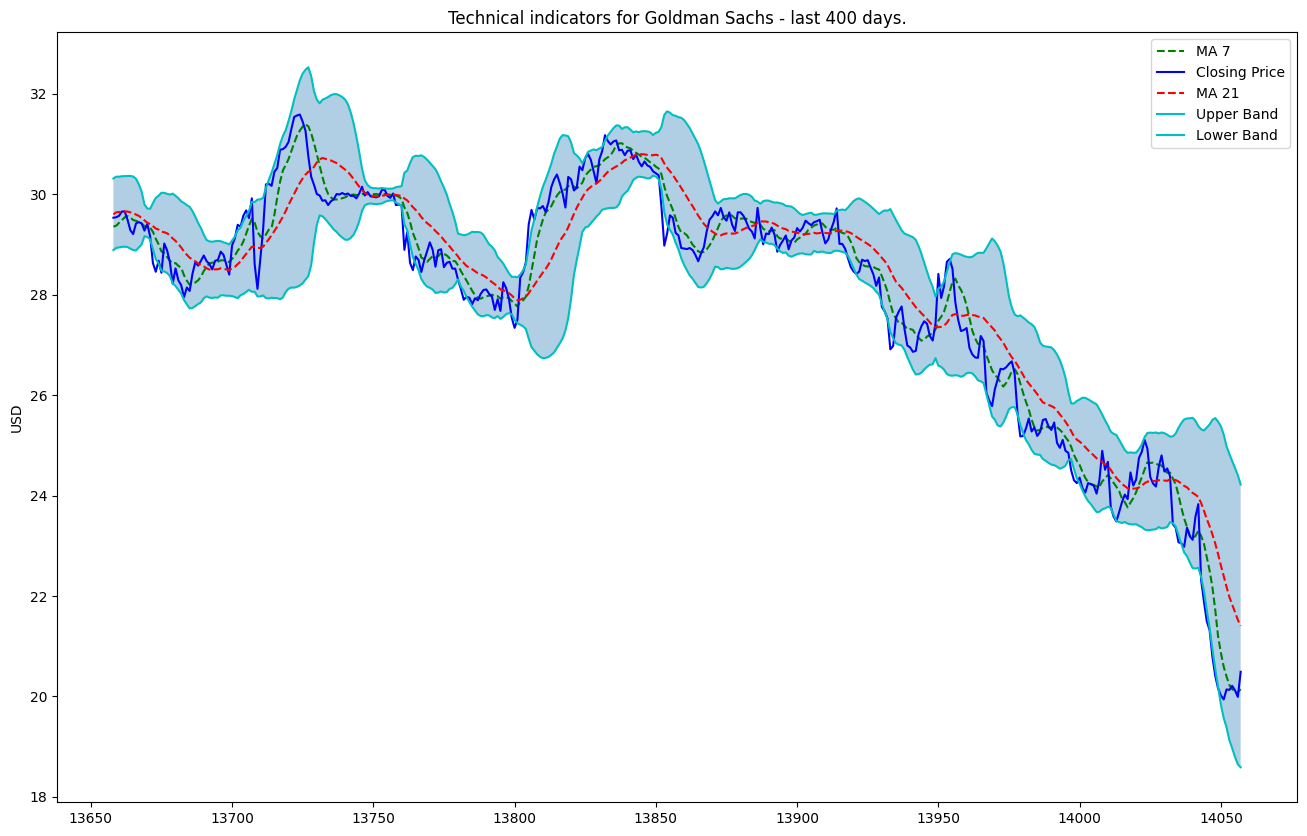

In [153]:
plot_technical_indicators(dataset_TI_gs, 400)

In [154]:
#files.download('in')

In [155]:
dataset_TI_gs

,Date,Adj,ma7,ma21,26ema,20sd,upper_band,lower_band,ema,12ema
0,1962-01-02,0.6201,10.534214,10.534029,0.620100,0.268396,11.070858,9.997200,0.620100,0.620100
1,1962-01-03,0.6201,10.534214,10.534029,0.620100,0.268396,11.070858,9.997200,0.620100,0.620100
2,1962-01-04,0.6122,10.534214,10.534029,0.619515,0.268396,11.070858,9.997200,0.614631,0.618885
3,1962-01-05,0.5957,10.534214,10.534029,0.617751,0.268396,11.070858,9.997200,0.601853,0.615318
4,1962-01-08,0.5957,10.534214,10.534029,0.616117,0.268396,11.070858,9.997200,0.597734,0.612300
...,...,...,...,...,...,...,...,...,...,...
14053,2017-11-06,20.1300,20.227143,21.980476,22.005934,1.424942,24.830360,19.130593,20.117657,20.942840
14054,2017-11-07,20.2100,20.144286,21.827143,21.872902,1.430081,24.687305,18.966981,20.179219,20.830095
14055,2017-11-08,20.1200,20.102857,21.672857,21.743057,1.438929,24.550715,18.794999,20.139740,20.720850
14056,2017-11-09,19.9900,20.078571,21.526190,21.613201,1.439656,24.405503,18.646878,20.039913,20.608411


##  ***3.4. Fourier transforms for trend analysis***



In [156]:
##Visualize Correlated Stocks

###Visaulise 400 days
def plot_fouriers(dataset):
    close_fft = np.fft.fft(np.asarray(dataset.iloc[:, 1].tolist()))
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    plt.figure(figsize=(18, 5), dpi=100)
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [3, 6, 9, 100]:
        fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
        plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    plt.plot(dataset.iloc[:, 0],  label='Real')
    plt.xlabel('Days')
    plt.ylabel('USD')
    plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
    plt.legend()
    plt.show()

In [157]:
def fourier_tr(dataset,num_):
    close_fft = np.fft.fft(np.asarray(dataset.iloc[:, 1].tolist()))
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    return np.fft.ifft(fft_list_m10)

In [158]:
##Visualize Correlated Stocks

###Visaulise 400 days
def plot_fouriers(dataset,n1,n2,n3,n4):
    plt.figure(figsize=(18, 5), dpi=100)
    for num_ in [n1,n2,n3,n4]:
        plt.plot(fourier_tr(dataset,num_), label='Fourier transform with {} components'.format(num_))
    plt.plot(dataset.iloc[:, 1],  label='Real')
    plt.xlabel('Days')
    plt.ylabel('USD')
    plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
    plt.legend()
    plt.savefig("four.png")
    plt.show()

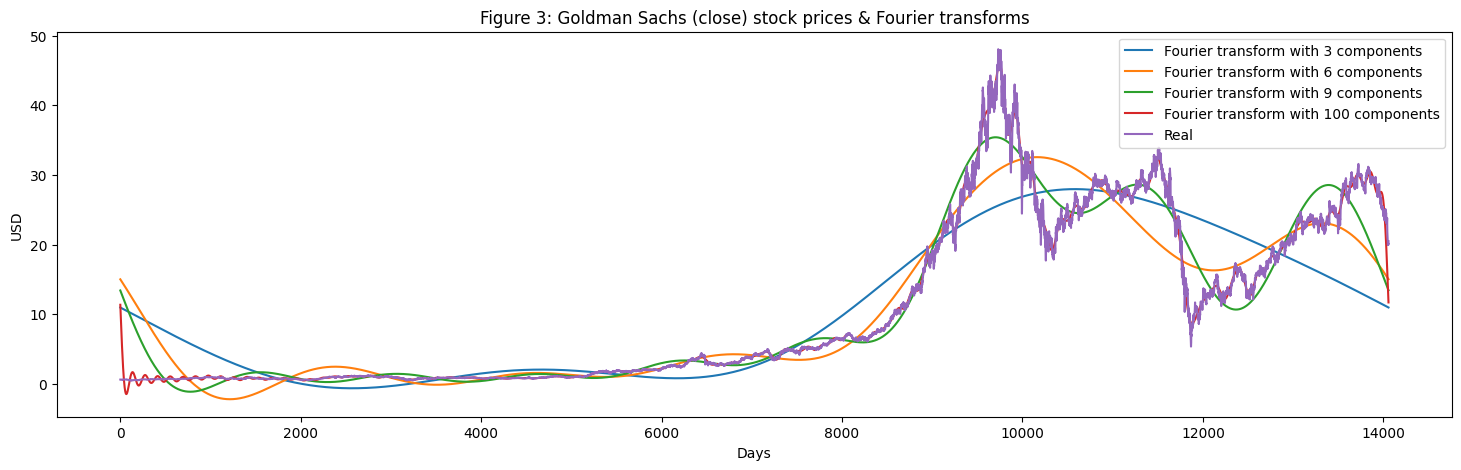

In [159]:
plot_fouriers(df_gs,3, 6, 9, 100)

In [160]:
##Wavelet

#from collections import deque
#items = deque(np.asarray(fft_df['absolute'].tolist()))
#items.rotate(int(np.floor(len(fft_df)/2)))
#plt.figure(figsize=(10, 7), dpi=80)
#plt.stem(items)
#plt.title('Figure 4: Components of Fourier transforms')
#plt.show()

In [161]:
##Appending Fourier transforms of 3,6,9 to Features##
###GS
#dataset_TI_gs['Fourier3'] = fourier_tr(df_gs,3)
#dataset_TI_gs['Fourier6'] = fourier_tr(df_gs,6)
#dataset_TI_gs['Fourier9'] = fourier_tr(df_gs,9)








## **3.7. Feature Engineering**

### **3.7.0. Aggregate All Features**

In [162]:
dataset_total = dataset_TI_gs.copy()

In [163]:
print('Total dataset has {} samples, and {} features.'.format(dataset_total.shape[0], \
                                                              dataset_total.shape[1]))

Total dataset has 14058 samples, and 10 features.


In [164]:
dataset_total

,Date,Adj,ma7,ma21,26ema,20sd,upper_band,lower_band,ema,12ema
0,1962-01-02,0.6201,10.534214,10.534029,0.620100,0.268396,11.070858,9.997200,0.620100,0.620100
1,1962-01-03,0.6201,10.534214,10.534029,0.620100,0.268396,11.070858,9.997200,0.620100,0.620100
2,1962-01-04,0.6122,10.534214,10.534029,0.619515,0.268396,11.070858,9.997200,0.614631,0.618885
3,1962-01-05,0.5957,10.534214,10.534029,0.617751,0.268396,11.070858,9.997200,0.601853,0.615318
4,1962-01-08,0.5957,10.534214,10.534029,0.616117,0.268396,11.070858,9.997200,0.597734,0.612300
...,...,...,...,...,...,...,...,...,...,...
14053,2017-11-06,20.1300,20.227143,21.980476,22.005934,1.424942,24.830360,19.130593,20.117657,20.942840
14054,2017-11-07,20.2100,20.144286,21.827143,21.872902,1.430081,24.687305,18.966981,20.179219,20.830095
14055,2017-11-08,20.1200,20.102857,21.672857,21.743057,1.438929,24.550715,18.794999,20.139740,20.720850
14056,2017-11-09,19.9900,20.078571,21.526190,21.613201,1.439656,24.405503,18.646878,20.039913,20.608411


In [165]:
len(dataset_total.columns)

10

### **3.7.1. Feature importance with XGBoost**

In [166]:
dataset_total.set_index('Date', inplace=True)
#dataset_TI_gs.set_index('Date', inplace=True)

In [167]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Adj']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [168]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_total)
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=100,base_score=0.9,colsample_bytree=1,learning_rate=0.14)

In [169]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [170]:
eval_result = regressor.evals_result()

In [171]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

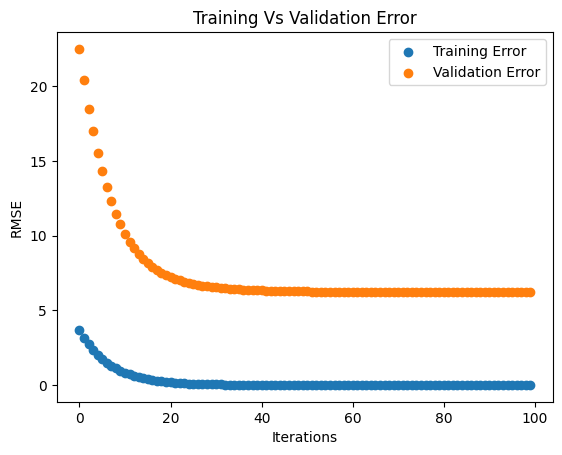

In [172]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

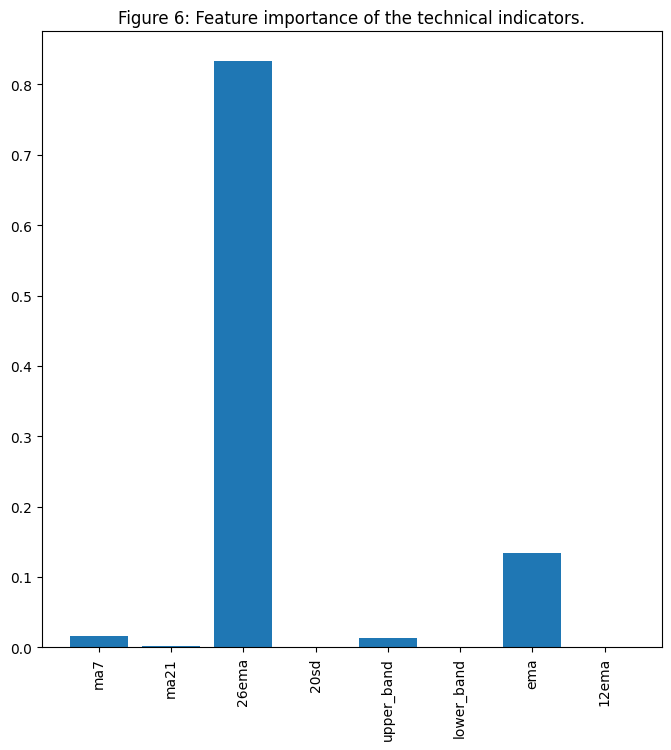

In [173]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

In [174]:
len(dataset_total.columns)

9

# **4.Bi-LSTM**

In [175]:
##Hypter Parameters' Range
params = {
    "batch_size": 16,  # 20<16<10, 25 was a bust
    "epochs": 500,
    "lr": 0.0000100,
    "time_steps": 30
}

iter_changes = "dropout_layers_0.5_0.5"

In [176]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [177]:
##Create output path

#INPUT_PATH ='/tmp/Jupyter/lstm'+"/inputs"
#OUTPUT_PATH = 'drive/MyDrive//Kuliah/MLProject'+iter_changes
#TIME_STEPS = params["time_steps"]
#BATCH_SIZE = params["batch_size"]
#stime = time.time()



  ## check if directory already exists
#if not os.path.exists(OUTPUT_PATH):
#    os.makedirs(OUTPUT_PATH)
#    print("Directory created", OUTPUT_PATH)
#else:
#    raise Exception("Directory already exists. Don't override.")

#def print_time(text, stime):
#    seconds = (time.time()-stime)
#    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")


import shutil

## Create output path
OUTPUT_PATH = 'drive/MyDrive/Kuliah/MLProject' + iter_changes
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

## Override existing directory
if os.path.exists(OUTPUT_PATH):
    shutil.rmtree(OUTPUT_PATH)
os.makedirs(OUTPUT_PATH)
print("Directory created/overridden:", OUTPUT_PATH)

def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")

print_time("Elapsed time:", stime)



Directory created/overridden: drive/MyDrive/Kuliah/MLProjectdropout_layers_0.5_0.5
Elapsed time: 0.0 minutes :  0.0 seconds


In [178]:

##Trim dataset based on batch size    
    
def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat
##Build timeseries based on time steps (For example if we have 3 time steps, we want our network to look back on 3 days of data to predict price on 4th day)

def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y



In [179]:
df_train

,Date,GS
0,1962-01-02,0.6201
1,1962-01-03,0.6201
2,1962-01-04,0.6122
3,1962-01-05,0.5957
4,1962-01-08,0.5957
...,...,...
11241,2006-09-06,27.3340
11242,2006-09-07,27.4050
11243,2006-09-08,27.3820
11244,2006-09-11,27.7180


In [180]:
df_test

,Date,GS
11246,2006-09-13,28.049
11247,2006-09-14,28.003
11248,2006-09-15,28.058
11249,2006-09-18,28.073
11250,2006-09-19,28.058
...,...,...
14053,2017-11-06,20.130
14054,2017-11-07,20.210
14055,2017-11-08,20.120
14056,2017-11-09,19.990


In [181]:
## split
L = []
for i in range(9):
  L.append(i)
##


df_train, df_test = train_test_split(dataset_total.iloc[:,L], train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.iloc[:,L].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.iloc[:,L])

#print("Deleting unused dataframes of total size(KB)",(sys.getsizeof(df_ge)+sys.getsizeof(df_train)+sys.getsizeof(df_test))//1024)

#del dataset_total
#del df_test
#del df_train
#del x

print("Are any NaNs present in train/test matrices?",np.isnan(x_train).any(), np.isnan(x_train).any())
x_t, y_t = build_timeseries(x_train, 0)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)

Train--Test size 11246 2812
Are any NaNs present in train/test matrices? False False
dim_0 11216


  0%|          | 0/11216 [00:00<?, ?it/s]

length of time-series i/o (11216, 30, 9) (11216,)
Batch trimmed size (11216, 30, 9) (11216,)


In [182]:
x_train.shape

(11246, 9)

In [183]:
x_test.shape

(2812, 9)

In [184]:


x_temp, y_temp = build_timeseries(x_test, 0)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

dim_0 2782


  0%|          | 0/2782 [00:00<?, ?it/s]

length of time-series i/o (2782, 30, 9) (2782,)


In [185]:
tt = trim_dataset(x_test_t, BATCH_SIZE)
ytt = y_test_t 
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)


In [186]:
ytt.shape

(1384,)

In [187]:
tt.shape

(1376, 30, 9)

In [188]:
y_test_t.shape

(1376,)

In [189]:


#def create_model():
#    lstm_model = Sequential()
#    # (batch_size, timesteps, data_dim)
#    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
#                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
#                        kernel_initializer='random_uniform'))
#    lstm_model.add(Dropout(0.4))
#    lstm_model.add(LSTM(60, dropout=0.0))
#    lstm_model.add(Dropout(0.4))
#    lstm_model.add(Dense(20,activation='relu'))
#   lstm_model.add(Dense(1,activation='sigmoid'))
#   optimizer = optimizers.RMSprop(lr=params["lr"])
#   # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
#   lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
#    return lstm_model


from keras.layers import Bidirectional

def create_bilstm_model():
    bilstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    bilstm_model.add(Bidirectional(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                                        kernel_initializer='random_uniform')))
    bilstm_model.add(Dropout(0.4))
    bilstm_model.add(Bidirectional(LSTM(60, dropout=0.0)))
    bilstm_model.add(Dropout(0.4))
    bilstm_model.add(Dense(20, activation='relu'))
    bilstm_model.add(Dense(1, activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    bilstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return bilstm_model

bilstm_model = create_bilstm_model()


model = None
try:
    model = pickle.load(open("bilstm_model", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")


x_temp, y_temp = build_timeseries(x_test, 0)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)
    
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
    #print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_bilstm_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    # Not used here. But leaving it here as a reminder for future
    r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
  

Model not found
dim_0 2782


  0%|          | 0/2782 [00:00<?, ?it/s]

length of time-series i/o (2782, 30, 9) (2782,)
Test size (1384, 30, 9) (1384,) (1384, 30, 9) (1384,)
Building model...


In [190]:
  
history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])

print("saving model...")
pickle.dump(model, open("bilstm_model", "wb"))


Epoch 1/500

Epoch 1: val_loss improved from inf to 0.04802, saving model to drive/MyDrive/Kuliah/MLProjectdropout_layers_0.5_0.5/best_model.h5
701/701 - 29s - loss: 0.1775 - val_loss: 0.0480 - 29s/epoch - 42ms/step
Epoch 2/500

Epoch 2: val_loss improved from 0.04802 to 0.03270, saving model to drive/MyDrive/Kuliah/MLProjectdropout_layers_0.5_0.5/best_model.h5
701/701 - 6s - loss: 0.0920 - val_loss: 0.0327 - 6s/epoch - 9ms/step
Epoch 3/500

Epoch 3: val_loss improved from 0.03270 to 0.02199, saving model to drive/MyDrive/Kuliah/MLProjectdropout_layers_0.5_0.5/best_model.h5
701/701 - 8s - loss: 0.0505 - val_loss: 0.0220 - 8s/epoch - 11ms/step
Epoch 4/500

Epoch 4: val_loss improved from 0.02199 to 0.00585, saving model to drive/MyDrive/Kuliah/MLProjectdropout_layers_0.5_0.5/best_model.h5
701/701 - 7s - loss: 0.0210 - val_loss: 0.0058 - 7s/epoch - 9ms/step
Epoch 5/500

Epoch 5: val_loss improved from 0.00585 to 0.00142, saving model to drive/MyDrive/Kuliah/MLProjectdropout_layers_0.5_0.

In [191]:

# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
MSEE = mean_squared_error(y_test_t, y_pred)
r2score = r2_score(y_test_t, y_pred)
print("MSE is", MSEE, y_pred.shape, y_test_t.shape)
print("R2 is", r2score, y_pred.shape, y_test_t.shape)

print(y_pred[0:15])
print(y_test_t[0:15])


86/86 [==============================] - 2s 4ms/step
MSE is 0.0005651030794243916 (1376,) (1376,)
R2 is 0.9199102010611968 (1376,) (1376,)
[0.35666275 0.3568888  0.35705498 0.35717556 0.35732576 0.35748264
 0.35767153 0.35787362 0.3580332  0.35812965 0.35813808 0.35804337
 0.35791326 0.35771796 0.3573339 ]
[0.3338653  0.33682767 0.339685   0.33615536 0.34004216 0.3394749
 0.33665959 0.33189038 0.33155423 0.33031465 0.32428486 0.32747834
 0.32607069 0.31886435 0.31529269]


In [192]:

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])


[17.435091 17.44585  17.45376  17.4595   17.466648 17.474115 17.483105
 17.492725 17.50032  17.504911 17.505312 17.500805 17.494612 17.485315
 17.467035]
[16.35  16.491 16.627 16.459 16.644 16.617 16.483 16.256 16.24  16.181
 15.894 16.046 15.979 15.636 15.466]


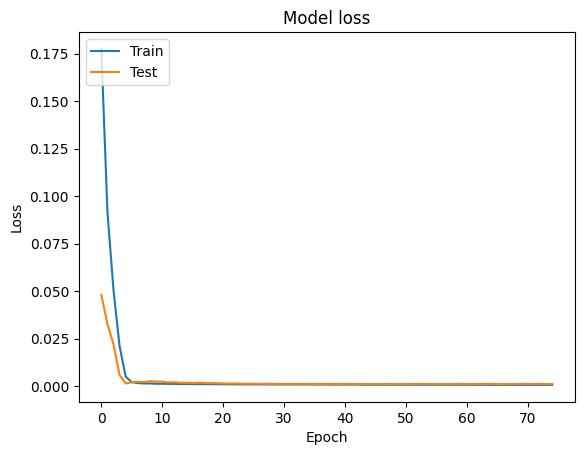

In [193]:

# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('train-val-loss.png')
plt.show()



In [194]:
files.download('train-val-loss.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [195]:

# load the saved best model from above
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)

y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])


86/86 [==============================] - 2s 4ms/step
Error is 0.0005928299415073523 (1376,) (1376,)
[0.39564264 0.3955913  0.39555308 0.39550793 0.3954397  0.3954198
 0.39543444 0.3954321  0.39540786 0.39537513 0.39528102 0.39509764
 0.394921   0.39472842 0.39441717]
[0.3338653  0.33682767 0.339685   0.33615536 0.34004216 0.3394749
 0.33665959 0.33189038 0.33155423 0.33031465 0.32428486 0.32747834
 0.32607069 0.31886435 0.31529269]
[19.290417 19.287971 19.286154 19.284004 19.280758 19.27981  19.280506
 19.280396 19.279242 19.277683 19.273203 19.264475 19.256067 19.246902
 19.232086]
[16.35  16.491 16.627 16.459 16.644 16.617 16.483 16.256 16.24  16.181
 15.894 16.046 15.979 15.636 15.466]


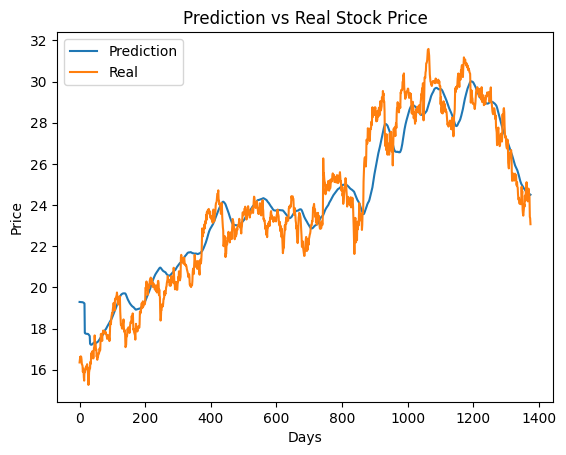

program completed  9.0 minutes :  46.0 seconds


In [196]:

# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.savefig('result-pred.png')
plt.show()

print_time("program completed ", stime)

In [197]:
files.download('result-pred.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [198]:
y_pred_org[300:3500]

array([21.046186, 21.068188, 21.090935, ..., 24.529528, 24.51604 ,
       24.502226], dtype=float32)

In [199]:
y_test_t_org[300:3500]

array([20.246, 20.503, 20.434, ..., 23.43 , 23.36 , 23.07 ])

In [200]:
#fig = px.line(df_gs, y=y_test_t_org,text='Real')
fig = go.Figure()
fig.add_scatter(y=y_test_t_org, mode='lines',name='Real')
fig.add_scatter(y=y_pred_org, mode='lines',name='Prediction')

fig.show()



# Show plot 

In [201]:
#probe-pred = model.predict(x_t, batch_size=BATCH_SIZE)
y_pred = model.predict(x_t, batch_size=BATCH_SIZE)
#probe-pred = probe-pred.flatten()




701/701 [==============================] - 4s 6ms/step


In [202]:
y_pred

array([[0.25170684],
       [0.25141573],
       [0.25109187],
       ...,
       [0.5404901 ],
       [0.54098976],
       [0.5415145 ]], dtype=float32)

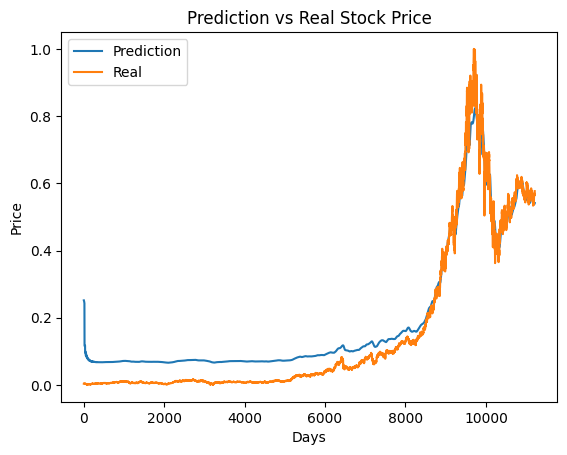

program completed  9.0 minutes :  51.0 seconds


In [203]:

# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred)
plt.plot(y_t)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.savefig('result-pred.png')
plt.show()

print_time("program completed ", stime)